Look into twitter text data to predict if the given text has positive or negative
sentiment towards a particular brand. The dataset includes twitter text related to
Apple and Google products with user sentiment ranked between ‘positive’,
‘negative’, ‘neutral’ and ‘no_idea’, sentiments. Create a simpleRNN or LSTM based
classifiers to classify tweets into the four classes. You can avoid
‘emotion_in_tweet_is_directed_at’ column.

In [ ]:
# libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:

# Define column names and encoding
DATASET_COLUMNS = ['tweet', 'elecronics','emotion', ]
DATASET_ENCODING = "ISO-8859-1"

# Load the CSV
df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS, header=None)
df

,tweet,elecronics,emotion
0,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_pro...
1,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
2,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
3,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
4,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
...,...,...,...
9089,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9090,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9091,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9092,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


Basic information

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9094 entries, tweet_text to Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link}
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  3292 non-null   object
 1   emotion     9094 non-null   object
dtypes: object(2)
memory usage: 471.2+ KB


,tweet_text,emotion
count,3292,9094
unique,10,5
top,iPad,No emotion toward brand or product
freq,946,5389


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9094 entries, tweet_text to Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @mention Google Tests ÛÏCheck-in OffersÛ At #SXSW {link}
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  3292 non-null   object
 1   emotion     9094 non-null   object
dtypes: object(2)
memory usage: 471.2+ KB


In [ ]:
print(df.isnull().sum())

tweet_text    5802
emotion          0
dtype: int64


In [ ]:
# Drop the first row by index (index 0)
df = df.drop(index=0).reset_index(drop=True)
df.head(3)

,tweet,elecronics,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [ ]:
print(df.columns)
print(df['emotion'].value_counts())

Index(['tweet', 'elecronics', 'emotion'], dtype='object')
emotion
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


In [ ]:
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['clean_tweet'] = df['tweet'].apply(clean_tweet)
df['clean_tweet']

,clean_tweet
0,g iphone hrs tweeting riseaustin dead need upg...
1,know awesome ipadiphone app youll likely appre...
2,wait ipad also sale sxsw
3,hope years festival isnt crashy years iphone a...
4,great stuff fri sxsw marissa mayer google tim ...
...,...
9088,ipad everywhere sxsw link
9089,wave buzz rt interrupt regularly scheduled sxs...
9090,googles zeiger physician never reported potent...
9091,verizon iphone customers complained time fell ...


In [ ]:
#check for null values
df.isnull().sum()


,0
tweet,1
emotion,0
clean_tweet,0


Encode Labels

In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['emotion'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{"I can't tell": np.int64(0), 'Negative emotion': np.int64(1), 'No emotion toward brand or product': np.int64(2), 'Positive emotion': np.int64(3)}


Train-Test Split

In [ ]:
x = df['clean_tweet']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode labels
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

Tokenization & Padding



In [ ]:
max_words = 10000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


Build the LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 Train the Model




In [ ]:
history = model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.5703 - loss: 1.0535 - val_accuracy: 0.6154 - val_loss: 0.8389
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.6511 - loss: 0.8019 - val_accuracy: 0.6786 - val_loss: 0.7787
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.7966 - loss: 0.5501 - val_accuracy: 0.6868 - val_loss: 0.8256
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.8535 - loss: 0.4134 - val_accuracy: 0.6745 - val_loss: 0.9177
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8786 - loss: 0.3231 - val_accuracy: 0.6731 - val_loss: 1.0500


Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6572 - loss: 1.1212
Test Accuracy: 0.6586


Plot Accuracy



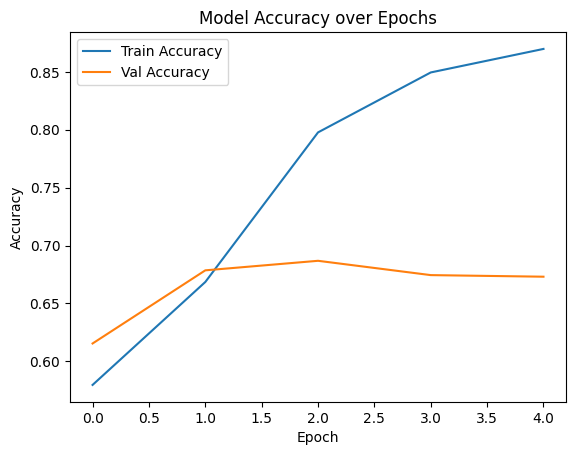

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
